In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import time
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import random
import torch.nn.init
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim import lr_scheduler
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from multiprocessing import cpu_count
from torch.utils.data import random_split
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def set_seed(seed=112):
    random.seed(seed)  # Python의 랜덤 시드 고정
    np.random.seed(seed)  # NumPy의 랜덤 시드 고정
    torch.manual_seed(seed)  # PyTorch의 CPU 시드 고정
    torch.cuda.manual_seed(seed)  # PyTorch의 GPU 시드 고정 (CUDA 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU의 시드 고정
    torch.backends.cudnn.deterministic = True  # 매번 같은 결과를 보장
    torch.backends.cudnn.benchmark = False  # 성능보다는 결과 재현성 우선

# 시드 설정 호출
set_seed(112)

In [ ]:
# device setting
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' device:', device)

Using PyTorch version: 2.5.0+cu121  device: cuda


In [ ]:
# Define the custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels.iloc[idx, 0]
        image = Image.open(os.path.join(self.img_dir, filename)).convert('RGB')
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        return image, label

    def get_labels(self):
        return self.img_labels.iloc[:, 1].tolist()

In [ ]:
# CustomSubset 클래스 정의
class CustomSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
class GaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.RandomApply([GaussianNoise(mean=0.0, std=0.1)], p=0.5),  # 가우시안 노이즈 추가
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
# train_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomRotation(45),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.CenterCrop(224),
#     transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),  # 가우시안 블러 p=0.5 적용
#     transforms.RandomApply([GaussianNoise(mean=0.0, std=0.05)], p=0.5),  # 가우시안 노이즈 추가
#     transforms.RandomApply([SaltAndPepperNoise(salt_prob=0.01, pepper_prob=0.01)], p=0.5),  # Salt and Pepper 노이즈 추가
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

In [ ]:
test_transform = transforms.Compose([
     transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [ ]:
# train
annotation_file = '/content/drive/MyDrive/AI 팩토리/task1/task1/train_labels.csv'
img_dir = '/content/drive/MyDrive/AI 팩토리/task1/task1/train'
train_custom = CustomImageDataset(annotation_file, img_dir)
# train_custom = CustomImageDataset(annotation_file, img_dir, transform=train_transform)

In [ ]:
# 전체 데이터셋의 길이
dataset_size = len(train_custom)

# 8:2 비율로 데이터셋을 분할
train_size = int(dataset_size * 0.8)
valid_size = dataset_size - train_size

# 데이터셋을 랜덤하게 분할
train_data, valid_data = random_split(train_custom, [train_size, valid_size])

# 데이터셋 크기 확인
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(valid_data)}")

Train dataset size: 2800
Validation dataset size: 700


In [ ]:
# 각각의 데이터셋에 맞는 변환 적용
train_dataset = CustomSubset(train_data, transform=train_transform)
valid_dataset = CustomSubset(valid_data, transform=test_transform)

In [ ]:
# test
annotation_file2 = '/content/drive/MyDrive/AI 팩토리/task1/task1/answer_sample.csv'
img_dir2 = '/content/drive/MyDrive/AI 팩토리/task1/task1/test'
test_custom = CustomImageDataset(annotation_file2, img_dir2, transform=test_transform)

In [ ]:
num_workers = int(cpu_count() / 2)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_custom, batch_size=16, shuffle=False)

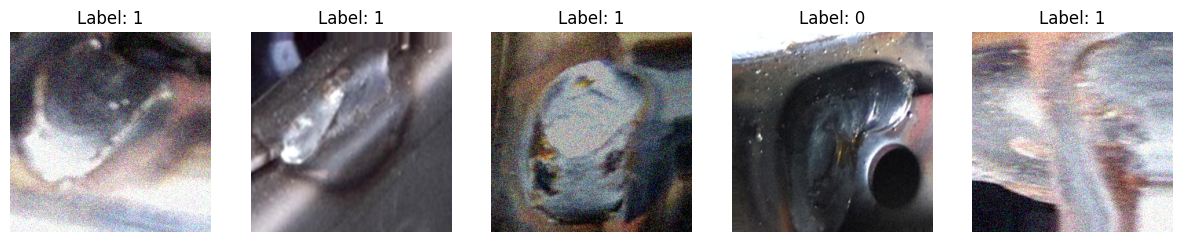

In [ ]:
# 샘플 이미지 5장 시각화 함수
def visualize_samples(dataloader, num_samples=5):
    # 데이터 로더에서 배치 하나를 가져옵니다.
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # 이미지 변환이 제대로 적용된 것을 시각화합니다.
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image = images[i].cpu().numpy().transpose(1, 2, 0)  # 채널 위치 변경
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean  # 정규화 해제
        image = np.clip(image, 0, 1)  # 값 범위 조정

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Label: {labels[i].item()}')
    plt.show()

# 함수 호출
visualize_samples(train_loader)

In [ ]:
model = models.wide_resnet101_2(pretrained=True)
num_ftrs = model.fc.in_features
half_in_size = round(num_ftrs/2)
layer_width = 1024
Num_class=2

class SpinalNet(nn.Module):
    def __init__(self, Input_Size, Number_of_Split, HL_width, number_HL, Output_Size, Activation_Function):

        super(SpinalNet, self).__init__()
        Splitted_Input_Size = int(np.round(Input_Size/Number_of_Split))
        self.lru = Activation_Function
        self.fc1 = nn.Linear(Splitted_Input_Size, HL_width)
        if number_HL>1:
            self.fc2 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>2:
            self.fc3 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>3:
            self.fc4 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>4:
            self.fc5 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>5:
            self.fc6 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>6:
            self.fc7 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>7:
            self.fc8 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>8:
            self.fc9 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>9:
            self.fc10 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>10:
            self.fc11 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>11:
            self.fc12 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>12:
            self.fc13 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>13:
            self.fc14 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>14:
            self.fc15 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>15:
            self.fc16 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>16:
            self.fc17 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>17:
            self.fc18 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>18:
            self.fc19 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>19:
            self.fc20 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>20:
            self.fc21 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>21:
            self.fc22 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>22:
            self.fc23 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>23:
            self.fc24 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>24:
            self.fc25 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>25:
            self.fc26 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>26:
            self.fc27 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>27:
            self.fc28 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>28:
            self.fc29 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        if number_HL>29:
            self.fc30 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)

        self.fcx = nn.Linear(HL_width*number_HL, Output_Size)

    def forward(self, x):
        x_all =x

        Splitted_Input_Size = self.fc1.in_features
        HL_width = self.fc2.in_features - self.fc1.in_features
        number_HL = int(np.round(self.fcx.in_features/HL_width))
        length_x_all = number_HL*Splitted_Input_Size

        while x_all.size(dim=1) < length_x_all:
            x_all = torch.cat([x_all, x],dim=1)

        x = self.lru(self.fc1(x_all[:,0:Splitted_Input_Size]))
        x_out = x

        counter1 = 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc2(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc3(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc4(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc5(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc6(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc7(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc8(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc9(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc10(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc11(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc12(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc13(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc14(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc15(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc16(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc17(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc18(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc19(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc20(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)
        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc21(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc22(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc23(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc24(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc25(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc26(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc27(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc28(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc29(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)

        counter1 = counter1 + 1
        if number_HL>counter1:
            x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
            x = self.lru(self.fc30(torch.cat([x_from_all, x], dim=1)))
            x_out = torch.cat([x_out, x], dim=1)
        #print("Size before output layer:",x_out.size(dim=1))
        x = self.fcx(x_out)
        return x

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth
100%|██████████| 243M/243M [00:01<00:00, 200MB/s]


In [ ]:
model.fc = SpinalNet(Input_Size = num_ftrs, Number_of_Split =2, HL_width=1024, number_HL=30, Output_Size=Num_class, Activation_Function = nn.ReLU(inplace=True))

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [ ]:
# class_weights = [1.2, 1.0]
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# class_weights

In [ ]:
# # 타겟 클래스가 포함된 리스트 또는 배열
# targets = np.array([label for _, label in train_loader.dataset])

# # 클래스 가중치 계산
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)

# # 클래스 가중치를 텐서로 변환하여 장치에 맞춤
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
epochs = 300
lr = 0.0001
criterion = nn.CrossEntropyLoss()
base_optimizer = torch.optim.Adam
optimizer = SAM(model.parameters(), base_optimizer, lr=lr)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [ ]:
early_stopping_patience = 7
best_valid_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()

    train_loss = 0
    train_correct = 0
    train_preds = []
    train_labels = []
    tqdm_dataset = tqdm(train_loader)

    for x, y in tqdm_dataset:
        x = x.to(device)
        y = y.to(device)

        # Define the closure function
        def closure():
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            return loss, outputs

        # Perform the first step
        loss, outputs = closure()
        optimizer.first_step(zero_grad=True)

        # Perform the second step
        _, outputs = closure()
        optimizer.second_step(zero_grad=True)

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()

        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(y.cpu().numpy())

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(loss.item()),
        })

    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(train_loader.sampler)
    train_f1 = f1_score(train_labels, train_preds, average='macro')

    model.eval()

    valid_loss = 0
    valid_correct = 0
    valid_preds = []
    valid_labels = []
    tqdm_dataset = tqdm(valid_loader)

    with torch.no_grad():
        for x, y in tqdm_dataset:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_correct += predicted.eq(y).sum().item()

            valid_preds.extend(predicted.cpu().numpy())
            valid_labels.extend(y.cpu().numpy())

            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(loss.item()),
            })

    valid_loss = valid_loss / len(valid_loader)
    valid_acc = valid_correct / len(valid_loader.sampler)
    valid_f1 = f1_score(valid_labels, valid_preds, average='macro')

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.6f}, Train F1: {train_f1:.6f}, Valid Loss: {valid_loss:.6f}, Valid Acc: {valid_acc:.6f}, Valid F1: {valid_f1:.6f}')

    # Move the scheduler step after optimizer step
    exp_lr_scheduler.step(valid_loss)

    # Check early stopping condition
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

100%|██████████| 44/44 [00:46<00:00,  1.05s/it, Epoch=1, Loss=0.000985]


Epoch 1, Train Loss: 0.152245, Train Acc: 0.868571, Train F1: 0.868130, Valid Loss: 0.037900, Valid Acc: 0.987143, Valid F1: 0.987057


100%|██████████| 44/44 [00:03<00:00, 12.52it/s, Epoch=2, Loss=0.001380]


Epoch 2, Train Loss: 0.041358, Train Acc: 0.962143, Train F1: 0.961986, Valid Loss: 0.016104, Valid Acc: 0.997143, Valid F1: 0.997119


100%|██████████| 44/44 [00:03<00:00, 12.50it/s, Epoch=3, Loss=0.005578]


Epoch 3, Train Loss: 0.021447, Train Acc: 0.978929, Train F1: 0.978828, Valid Loss: 0.008745, Valid Acc: 0.998571, Valid F1: 0.998558


100%|██████████| 44/44 [00:03<00:00, 12.42it/s, Epoch=4, Loss=0.001585]


Epoch 4, Train Loss: 0.018944, Train Acc: 0.983571, Train F1: 0.983492, Valid Loss: 0.013011, Valid Acc: 0.998571, Valid F1: 0.998558


100%|██████████| 44/44 [00:03<00:00, 12.44it/s, Epoch=5, Loss=0.000517]


Epoch 5, Train Loss: 0.016899, Train Acc: 0.980357, Train F1: 0.980267, Valid Loss: 0.000309, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.41it/s, Epoch=6, Loss=0.000026]


Epoch 6, Train Loss: 0.006569, Train Acc: 0.991786, Train F1: 0.991749, Valid Loss: 0.000594, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.44it/s, Epoch=7, Loss=0.022334]


Epoch 7, Train Loss: 0.003420, Train Acc: 0.992857, Train F1: 0.992823, Valid Loss: 0.006149, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.35it/s, Epoch=8, Loss=0.001717]


Epoch 8, Train Loss: 0.006343, Train Acc: 0.992500, Train F1: 0.992463, Valid Loss: 0.002266, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.46it/s, Epoch=9, Loss=0.001170]


Epoch 9, Train Loss: 0.001895, Train Acc: 0.989286, Train F1: 0.989234, Valid Loss: 0.000383, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.23it/s, Epoch=10, Loss=0.000727]


Epoch 10, Train Loss: 0.001349, Train Acc: 0.996786, Train F1: 0.996771, Valid Loss: 0.000147, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.44it/s, Epoch=11, Loss=0.000106]


Epoch 11, Train Loss: 0.000056, Train Acc: 0.999286, Train F1: 0.999282, Valid Loss: 0.000041, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.43it/s, Epoch=12, Loss=0.000169]


Epoch 12, Train Loss: 0.001787, Train Acc: 0.997857, Train F1: 0.997847, Valid Loss: 0.000036, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.48it/s, Epoch=13, Loss=0.000103]


Epoch 13, Train Loss: 0.000014, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000017, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.44it/s, Epoch=14, Loss=0.000069]


Epoch 14, Train Loss: 0.000034, Train Acc: 0.999643, Train F1: 0.999641, Valid Loss: 0.000009, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.43it/s, Epoch=15, Loss=0.000105]


Epoch 15, Train Loss: 0.000215, Train Acc: 0.999643, Train F1: 0.999641, Valid Loss: 0.000020, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.52it/s, Epoch=16, Loss=0.000033]


Epoch 16, Train Loss: 0.000055, Train Acc: 0.999286, Train F1: 0.999282, Valid Loss: 0.000006, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.39it/s, Epoch=17, Loss=0.000056]


Epoch 17, Train Loss: 0.000245, Train Acc: 0.998929, Train F1: 0.998924, Valid Loss: 0.000019, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.41it/s, Epoch=18, Loss=0.000002]


Epoch 18, Train Loss: 0.000025, Train Acc: 0.999286, Train F1: 0.999282, Valid Loss: 0.000002, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.38it/s, Epoch=19, Loss=0.000004]


Epoch 19, Train Loss: 0.000004, Train Acc: 0.999643, Train F1: 0.999641, Valid Loss: 0.000002, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.49it/s, Epoch=20, Loss=0.000002]


Epoch 20, Train Loss: 0.000006, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000001, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.43it/s, Epoch=21, Loss=0.000002]


Epoch 21, Train Loss: 0.000002, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000001, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.47it/s, Epoch=22, Loss=0.000001]


Epoch 22, Train Loss: 0.000002, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000001, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.33it/s, Epoch=23, Loss=0.000002]


Epoch 23, Train Loss: 0.000002, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.38it/s, Epoch=24, Loss=0.000001]


Epoch 24, Train Loss: 0.000004, Train Acc: 0.999643, Train F1: 0.999641, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.56it/s, Epoch=25, Loss=0.000001]


Epoch 25, Train Loss: 0.000001, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000001, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.39it/s, Epoch=26, Loss=0.000000]


Epoch 26, Train Loss: 0.000001, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.45it/s, Epoch=27, Loss=0.000000]


Epoch 27, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.28it/s, Epoch=28, Loss=0.000000]


Epoch 28, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.50it/s, Epoch=29, Loss=0.000000]


Epoch 29, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.31it/s, Epoch=30, Loss=0.000000]


Epoch 30, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.35it/s, Epoch=31, Loss=0.000000]


Epoch 31, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.41it/s, Epoch=32, Loss=0.000000]


Epoch 32, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.45it/s, Epoch=33, Loss=0.000000]


Epoch 33, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.41it/s, Epoch=34, Loss=0.000000]


Epoch 34, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.41it/s, Epoch=35, Loss=0.000000]


Epoch 35, Train Loss: 0.000000, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000000, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.37it/s, Epoch=36, Loss=0.000001]


Epoch 36, Train Loss: 0.000135, Train Acc: 0.998571, Train F1: 0.998565, Valid Loss: 0.000004, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.41it/s, Epoch=37, Loss=0.000008]


Epoch 37, Train Loss: 0.000012, Train Acc: 0.999643, Train F1: 0.999641, Valid Loss: 0.000019, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.41it/s, Epoch=38, Loss=0.000001]


Epoch 38, Train Loss: 0.000004, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000002, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.19it/s, Epoch=39, Loss=0.000001]


Epoch 39, Train Loss: 0.000024, Train Acc: 0.999643, Train F1: 0.999641, Valid Loss: 0.000001, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.27it/s, Epoch=40, Loss=0.000001]


Epoch 40, Train Loss: 0.000003, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000002, Valid Acc: 1.000000, Valid F1: 1.000000


100%|██████████| 44/44 [00:03<00:00, 12.37it/s, Epoch=41, Loss=0.000001]

Epoch 41, Train Loss: 0.000001, Train Acc: 1.000000, Train F1: 1.000000, Valid Loss: 0.000002, Valid Acc: 1.000000, Valid F1: 1.000000
Early stopping triggered after 41 epochs.


In [ ]:
# path = '/content/best_model.pth'
# model.load_state_dict(torch.load(path))

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/AI 팩토리/task1/task1/answer_sample.csv')

model.eval()

batch_index = 0

for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    outputs = model(images)

    # outputs의 예측 결과를 가져옵니다.
    max_vals, max_indices = torch.max(outputs, 1)

    # 할당할 데이터의 크기와 sample_submission의 크기를 일치시킵니다.
    sample_submission.iloc[batch_index:batch_index + len(images), 1:] = max_indices.long().cpu().numpy()[:, np.newaxis]

    # 배치 인덱스를 증가시킵니다.
    batch_index += len(images)

In [ ]:
sample_submission.to_csv('submit.csv',index=False)

In [ ]:
from google.colab import files

# submission.csv 파일 다운로드
files.download('submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>